#Book Recommendation system - Collaborative Filtering

##Read the dataset with the necessary features

In [ ]:
# Installing dependencies
!pip install pandas
!pip install matplotlib
!pip install numpy

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
books = pd.read_csv('/content/Books.csv', sep=',', on_bad_lines='skip', encoding="latin-1")
books.columns = ['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']
users = pd.read_csv('/content/Users.csv', sep=',', on_bad_lines='skip', encoding="latin-1")
users.columns = ['User-ID', 'Location', 'Age']
ratings = pd.read_csv('/content/Ratings.csv', sep=',', on_bad_lines='skip', encoding="latin-1")
ratings.columns = ['User-ID', 'ISBN', 'Book-Rating']

/tmp/ipython-input-3444512806.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('/content/Books.csv', sep=',', on_bad_lines='skip', encoding="latin-1")


In [ ]:
print(ratings.shape)
print(list(ratings.columns))

(1149780, 3)
['User-ID', 'ISBN', 'Book-Rating']


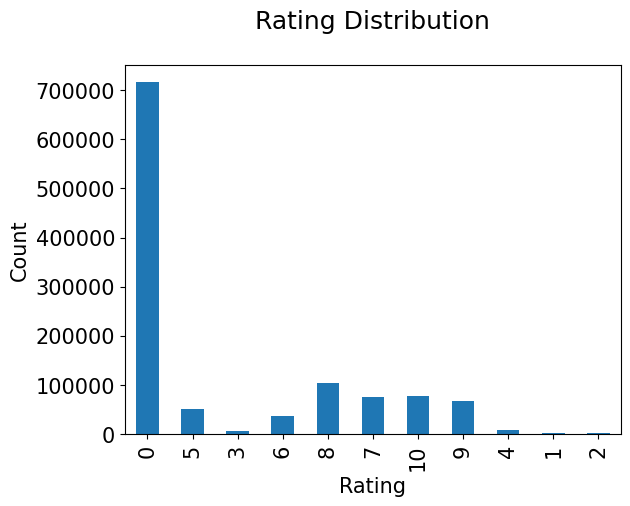

In [ ]:
plt.rc("font", size=15)
ratings['Book-Rating'].value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('system1.png', bbox_inches='tight')
plt.show()

In [ ]:
print(books.shape)
print(list(books.columns))

(271360, 8)
['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']


In [ ]:
print(users.shape)
print(list(users.columns))

(278858, 3)
['User-ID', 'Location', 'Age']


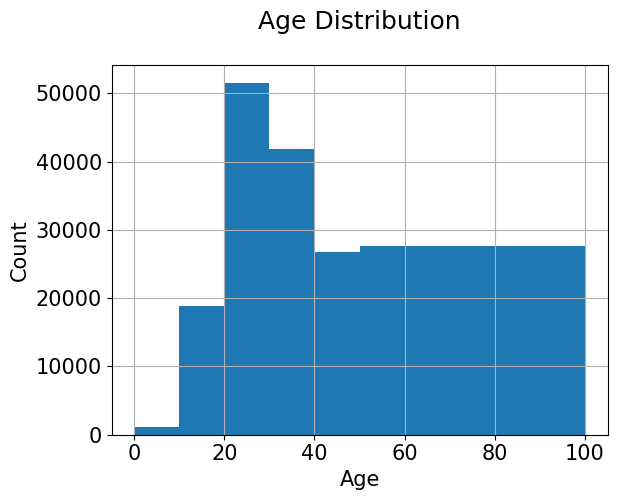

In [ ]:
users.Age.hist(bins=[0, 10, 20, 30, 40, 50, 100])
plt.title('Age Distribution\n')
plt.xlabel('Age')
plt.ylabel('Count')
plt.savefig('system2.png', bbox_inches='tight')
plt.show()

####Recommendation Based on Rating Counts

In [ ]:
rating_count = pd.DataFrame(ratings.groupby('ISBN')['Book-Rating'].count())
rating_count.sort_values('Book-Rating', ascending=False).head()

,Book-Rating
ISBN,
0971880107,2502
0316666343,1295
0385504209,883
0060928336,732
0312195516,723



The book with ISBN “0971880107” received the most rating counts. Now we will find what book it is along with the other 4.

In [ ]:
most_rated_books = pd.DataFrame(['0971880107', '0316666343', '0385504209', '0060928336', '0312195516'], index=np.arange(5), columns = ['ISBN'])
most_rated_books_summary = pd.merge(most_rated_books, books, on='ISBN')
most_rated_books_summary

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...
1,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...
2,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...
3,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...
4,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...


##Recommendations based on correlations

We use Pearsons’R correlation coefficient to measure the linear correlation between two variables, in our case, the ratings for two books.

First, we need to find out the average rating, and the number of ratings each book received.

In [ ]:
average_rating = pd.DataFrame(ratings.groupby('ISBN')['Book-Rating'].mean())
average_rating['ratingCount'] = pd.DataFrame(ratings.groupby('ISBN')['Book-Rating'].count())
average_rating.sort_values('ratingCount', ascending=False).head()

,Book-Rating,ratingCount
ISBN,,
0971880107,1.019584,2502
0316666343,4.468726,1295
0385504209,4.652322,883
0060928336,3.448087,732
0312195516,4.334716,723


Observations: In this data set, the book that received the most rating counts was not highly rated at all. As a result, if we were to use recommendations based on rating counts, we would definitely make mistakes here. So, we need to have a better system.

#To ensure statistical significance, users with less than 200 ratings, and books with less than 100 ratings are excluded.

In [ ]:
counts1 = ratings['User-ID'].value_counts()
ratings = ratings[ratings['User-ID'].isin(counts1[counts1 >= 200].index)]
counts = ratings['Book-Rating'].value_counts()
ratings = ratings[ratings['Book-Rating'].isin(counts[counts >= 100].index)]

##Rating matrix

We convert the ratings table to a 2D matrix. The matrix will be sparse because not every user rated every book.

In [ ]:
ratings_pivot = ratings.pivot(index='User-ID', columns='ISBN')['Book-Rating']
userID = ratings_pivot.index
ISBN = ratings_pivot.columns
print(ratings_pivot.shape)
ratings_pivot.head()

(905, 207699)


ISBN,0330299891,0375404120,0586045007,9022906116,9032803328,9044922564,9044922572,9044922718,9044923161,904492401X,...,UNGRANDHOMMED,X000000000,"YOUTELLEM,AND",ZR903CX0003,"\0432534220\""""","\2842053052\""""",b00005wz75,cn108465,cn113107,ÃÂ½crosoft
User-ID,,,,,,,,,,,,,,,,,,,,,
254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
bones_ratings = ratings_pivot['0316666343']
similar_to_bones = ratings_pivot.corrwith(bones_ratings)
corr_bones = pd.DataFrame(similar_to_bones, columns=['pearsonR'])
corr_bones.dropna(inplace=True)
corr_summary = corr_bones.join(average_rating['ratingCount'])
corr_summary[corr_summary['ratingCount']>=300].sort_values('pearsonR', ascending=False).head(10)

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,pearsonR,ratingCount
ISBN,,
0316666343,1.000000,1295
0312291639,0.471872,354
0316601950,0.434248,568
0446610038,0.429712,391
0446672211,0.421478,585
0385265700,0.351635,319
0345342968,0.316922,321
0060930535,0.309860,494
0375707972,0.308145,354


We obtained the books ISBNs, but we need to find out the titles of the books to see whether they make sense.

In [ ]:
books_corr_to_bones = pd.DataFrame(['0312291639', '0316601950', '0446610038', '0446672211', '0385265700', '0345342968', '0060930535', '0375707972', '0684872153'],
                                  index=np.arange(9), columns=['ISBN'])
corr_books = pd.merge(books_corr_to_bones, books, on='ISBN')
corr_books

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0312291639,The Nanny Diaries: A Novel,Emma McLaughlin,2003,St. Martin's Griffin,http://images.amazon.com/images/P/0312291639.0...,http://images.amazon.com/images/P/0312291639.0...,http://images.amazon.com/images/P/0312291639.0...
1,0316601950,The Pilot's Wife : A Novel,Anita Shreve,1999,Back Bay Books,http://images.amazon.com/images/P/0316601950.0...,http://images.amazon.com/images/P/0316601950.0...,http://images.amazon.com/images/P/0316601950.0...
2,0446610038,1st to Die: A Novel,James Patterson,2002,Warner Vision,http://images.amazon.com/images/P/0446610038.0...,http://images.amazon.com/images/P/0446610038.0...,http://images.amazon.com/images/P/0446610038.0...
3,0446672211,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts,1998,Warner Books,http://images.amazon.com/images/P/0446672211.0...,http://images.amazon.com/images/P/0446672211.0...,http://images.amazon.com/images/P/0446672211.0...
4,0385265700,The Book of Ruth (Oprah's Book Club (Paperback)),Jane Hamilton,1990,Anchor,http://images.amazon.com/images/P/0385265700.0...,http://images.amazon.com/images/P/0385265700.0...,http://images.amazon.com/images/P/0385265700.0...
5,0345342968,Fahrenheit 451,RAY BRADBURY,1987,Del Rey,http://images.amazon.com/images/P/0345342968.0...,http://images.amazon.com/images/P/0345342968.0...,http://images.amazon.com/images/P/0345342968.0...
6,0060930535,The Poisonwood Bible: A Novel,Barbara Kingsolver,1999,Perennial,http://images.amazon.com/images/P/0060930535.0...,http://images.amazon.com/images/P/0060930535.0...,http://images.amazon.com/images/P/0060930535.0...
7,0375707972,The Reader,Bernhard Schlink,1999,Vintage Books USA,http://images.amazon.com/images/P/0375707972.0...,http://images.amazon.com/images/P/0375707972.0...,http://images.amazon.com/images/P/0375707972.0...
8,0684872153,Angela's Ashes (MMP) : A Memoir,Frank McCourt,1999,Scribner,http://images.amazon.com/images/P/0684872153.0...,http://images.amazon.com/images/P/0684872153.0...,http://images.amazon.com/images/P/0684872153.0...


#Collaborative Filtering Using k-Nearest Neighbors (KNN)

KNN is a machine learning algorithm to find clusters of similar users based on common book ratings, and make predictions using the average rating of top-k nearest neighbors. For example, we first present ratings in a matrix with the matrix having one row for each item (book) and one column for each user,

In [ ]:
combine_book_rating = pd.merge(ratings, books, on='ISBN')
columns = ['Year-Of-Publication', 'Publisher', 'Book-Author', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']
combine_book_rating = combine_book_rating.drop(columns, axis=1)
combine_book_rating.head()

,User-ID,ISBN,Book-Rating,Book-Title
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...
1,277427,0026217457,0,Vegetarian Times Complete Cookbook
2,277427,003008685X,8,Pioneers
3,277427,0030615321,0,"Ask for May, Settle for June (A Doonesbury book)"
4,277427,0060002050,0,On a Wicked Dawn (Cynster Novels)


We then group by book titles and create a new column for total rating count.

In [ ]:
combine_book_rating = combine_book_rating.dropna(axis = 0, subset = ['Book-Title'])

book_ratingCount = (combine_book_rating.
     groupby(by = ['Book-Title'])['Book-Rating'].
     count().
     reset_index().
     rename(columns = {'Book-Rating': 'totalRatingCount'})
     [['Book-Title', 'totalRatingCount']]
    )
book_ratingCount.head()

,Book-Title,totalRatingCount
0,A Light in the Storm: The Civil War Diary of ...,2
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,Beyond IBM: Leadership Marketing and Finance ...,1
4,Clifford Visita El Hospital (Clifford El Gran...,1


We combine the rating data with the total rating count data, this gives us exactly what we need to find out which books are popular and filter out lesser-known books.

In [ ]:
rating_with_totalRatingCount = combine_book_rating.merge(book_ratingCount, left_on = 'Book-Title', right_on = 'Book-Title', how = 'left')
rating_with_totalRatingCount.head()

,User-ID,ISBN,Book-Rating,Book-Title,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
1,277427,0026217457,0,Vegetarian Times Complete Cookbook,7
2,277427,003008685X,8,Pioneers,1
3,277427,0030615321,0,"Ask for May, Settle for June (A Doonesbury book)",1
4,277427,0060002050,0,On a Wicked Dawn (Cynster Novels),13


In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(book_ratingCount['totalRatingCount'].describe())

count   160576.000
mean         3.044
std          7.428
min          1.000
25%          1.000
50%          1.000
75%          2.000
max        365.000
Name: totalRatingCount, dtype: float64


The median book has been rated only once. Let’s look at the top of the distribution

In [ ]:
print(book_ratingCount['totalRatingCount'].quantile(np.arange(.9, 1, .01)))

0.900    5.000
0.910    6.000
0.920    7.000
0.930    7.000
0.940    8.000
0.950   10.000
0.960   11.000
0.970   14.000
0.980   19.000
0.990   31.000
Name: totalRatingCount, dtype: float64


In [ ]:
popularity_threshold = 50
rating_popular_book = rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
rating_popular_book.head()

,User-ID,ISBN,Book-Rating,Book-Title,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
13,277427,0060930535,0,The Poisonwood Bible: A Novel,133
15,277427,0060934417,0,Bel Canto: A Novel,108
18,277427,0061009059,9,One for the Money (Stephanie Plum Novels (Pape...,108
24,277427,006440188X,0,The Secret Garden,79


In [ ]:
rating_popular_book.shape

(62149, 5)

##Filter to users in US and UK only

In [ ]:
combined = rating_popular_book.merge(users, left_on = 'User-ID', right_on = 'User-ID', how = 'left')

us_uk_user_rating = combined[combined['Location'].str.contains("usa|united kingdom")]
us_uk_user_rating=us_uk_user_rating.drop('Age', axis=1)
us_uk_user_rating.head()

,User-ID,ISBN,Book-Rating,Book-Title,totalRatingCount,Location
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82,"gilbert, arizona, usa"
1,277427,0060930535,0,The Poisonwood Bible: A Novel,133,"gilbert, arizona, usa"
2,277427,0060934417,0,Bel Canto: A Novel,108,"gilbert, arizona, usa"
3,277427,0061009059,9,One for the Money (Stephanie Plum Novels (Pape...,108,"gilbert, arizona, usa"
4,277427,006440188X,0,The Secret Garden,79,"gilbert, arizona, usa"


##Implementing KNN

We convert our table to a 2D matrix, and fill the missing values with zeros (since we will calculate distances between rating vectors). We then transform the values(ratings) of the matrix dataframe into a scipy sparse matrix for more efficient calculations.

Finding the Nearest Neighbors We use unsupervised algorithms with sklearn.neighbors. The algorithm we use to compute the nearest neighbors is “brute”, and we specify “metric=cosine” so that the algorithm will calculate the cosine similarity between rating vectors. Finally, we fit the model.

In [ ]:
from scipy.sparse import csr_matrix
us_uk_user_rating = us_uk_user_rating.drop_duplicates(['User-ID', 'Book-Title'])
us_uk_user_rating_pivot = us_uk_user_rating.pivot(index = 'Book-Title', columns = 'User-ID', values = 'Book-Rating').fillna(0)
us_uk_user_rating_matrix = csr_matrix(us_uk_user_rating_pivot.values)

from sklearn.neighbors import NearestNeighbors


model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(us_uk_user_rating_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
# Define the index of the book to query
query_index = us_uk_user_rating_pivot.index.get_loc('The Lovely Bones: A Novel')

us_uk_user_rating_pivot.iloc[query_index,:].values.reshape(1,-1)

array([[ 0.,  0.,  9.,  0.,  0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  8.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0., 10.,  7.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 10.,  0.,  9.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  7.,  0.,
         0.,  0.,  0.,  0.,  6.,  0.,  0.,  9.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  9.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  6.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  9.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  8.,  0.,  8.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  6.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  7.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., 10.,  0.,  0.,  0.,  0.,  0.,  5.,  0., 10.,  0.,  0.,
         0.,  0.,  9.,  7.,  0.,  0.,  0.,  0.,  0.

In [ ]:
query_index = np.random.choice(us_uk_user_rating_pivot.shape[0])
print(query_index)
distances, indices = model_knn.kneighbors(us_uk_user_rating_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)

31


In [ ]:
us_uk_user_rating_pivot.index[query_index]

'A Year in Provence'

In [ ]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(us_uk_user_rating_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, us_uk_user_rating_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for A Year in Provence:

1: Coraline, with distance of 0.7243342192444415:
2: Into the Wild, with distance of 0.7503040602090968:
3: How to Make an American Quilt, with distance of 0.7507099363597771:
4: Bridget Jones: The Edge of Reason, with distance of 0.7574549211047814:
5: The Hours : A Novel, with distance of 0.7800644002826849:


#Evaluation Metrics

The following code calculates key evaluation metrics to measure the accuracy and quality of the recommendation system, including RMSE and MAE for rating predictions, and Precision@K and Recall@K for top-K recommendation relevance.

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

Different Metric Functions Used.

In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def precision_at_k(recommended_items, relevant_items, k):
    recommended_k = recommended_items[:k]
    hits = len(set(recommended_k) & set(relevant_items))
    return hits / k if k else 0

def recall_at_k(recommended_items, relevant_items, k):
    recommended_k = recommended_items[:k]
    hits = len(set(recommended_k) & set(relevant_items))
    return hits / len(relevant_items) if len(relevant_items) > 0 else 0

In [ ]:
train, test = train_test_split(ratings, test_size=0.2, random_state=42)

mean_rating = train['Book-Rating'].mean()
y_true = test['Book-Rating'].values
y_pred = np.array([mean_rating] * len(test))

print("RMSE: ", round(rmse(y_true, y_pred), 4))
print("MAE: ", round(mae(y_true, y_pred), 4))

recommended_items = ['Coraline', 'Into the Wild', 'How to Make an American Quilt', 'Bridget Jones: The Edge of Reason', 'The Hours : A Novel']
relevant_items = ['A Painted House', 'The Golden Rule of Schmoozing', 'Adressat unbekannt.', 'False Memory']
k = 3

print("Precision@" + str(k) + ": ", round(precision_at_k(recommended_items, relevant_items, k), 4))
print("Recall@" + str(k) + ": ", round(recall_at_k(recommended_items, relevant_items, k), 4))

RMSE:  3.5196
MAE:  2.9571
Precision@3:  0.0
Recall@3:  0.0
